In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
import glob

import sys
sys.path.append('./../scripts')

from refuelplot import *
setup()
sns.set_style("white")

In [2]:
tx_path = '/data/projects/texas-power-outages/data/interim/'
fig_path = '/data/projects/texas-power-outages/data/figures/'
out_path = '/data/projects/texas-power-outages/data/output/'
in_path = '/data/projects/texas-power-outages/data/input/'
fig_path_raw = fig_path+'raw_data/'

# load data

### load outages

In [3]:
reduction= pd.read_csv(tx_path+'outages/outages_reduction.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')

### load temperature

In [4]:
# load power plant temperatures
temppp = pd.read_csv(tx_path + 'temperatures/temppowerplant.csv',index_col=0,parse_dates=True).tz_localize('UTC').tz_convert('Etc/GMT+6')

In [5]:
# load gas field temperatures
tempgf = pd.read_csv(tx_path + 'temperatures/temp_gasfields.csv',index_col=0,parse_dates=True).t2m.tz_convert('Etc/GMT+6')

In [6]:
# get temperature at windparks
tempwp = pd.read_csv(tx_path + 'temperatures/tempWP.csv',parse_dates=True,index_col=0).tz_convert('Etc/GMT+6').t2m
tempwpNS = pd.read_csv(tx_path + 'temperatures/tempWP_NSsplit.csv',parse_dates=True,index_col=0).tz_convert('Etc/GMT+6')
# get wind power
wp = pd.read_csv(tx_path + 'windpower/wpTXh.csv',parse_dates=True,index_col=0).tz_localize('UTC').tz_convert('Etc/GMT+6').wp

### load load

In [7]:
# get load
load = pd.read_csv(tx_path + 'load/load_est_LR24temptrend_Hook-8.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')
load70 = pd.read_csv(tx_path + 'load/load_est70_LR24_temptrend_Hook-8.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')

### load outage model results

In [8]:
out_model_param = pd.read_csv(out_path + 'outage_function_parameters/outage_function_parameters.cvs',index_col=0)

### threshold function

In [9]:
def get_thresh(temp,temp_fail,temp_recover,cap_loss,k):
    available_cap = pd.Series(0,index=temp.index)
    below_thresh = temp[temp<temp_fail].resample('M').count().replace(0,np.nan).dropna()
    ym = below_thresh.index.strftime("%Y-%m")
    h_recovery = int(-cap_loss/k)
    for i in range(len(below_thresh)):
        t1 = pd.to_datetime(ym[i])
        while(t1.strftime("%Y-%m")==ym[i]):
            t0 = (temp[t1:]<temp_fail).idxmax()
            t1 = (temp[(t0+np.timedelta64(10,'h')):]>temp_recover).idxmax()
            const_time = int((t1-t0)/np.timedelta64(1,'h'))
            t2 = t1 + np.timedelta64(h_recovery-1,'h')
            available_cap[t0:t2] = cap_loss + k*np.concatenate([np.array([0]*const_time),np.arange(h_recovery)])[:len(available_cap[t0:t2])]
            if sum(temp[t1:]<temp_fail)==0:
                break
    return(available_cap)

### marginal winterization costs
Million $ /GW

In [5]:
winterization_coal = 223.53
winterization_gas = 453.43
winterization_wind = 65

# scenarios reduced_outage

In [11]:
if tx_path + 'bootstrap_year.csv' in glob.glob(tx_path + '*.csv'):
    print('read bootstrap')
    bootstrap_year = np.genfromtxt(tx_path + 'bootstrap_year.csv', delimiter=',')
else:
    print('newly generate bootstrap')
    bootstrap_year = np.random.choice(np.arange(1950,2022),(10000,30))
    np.savetxt(tx_path + "bootstrap_year.csv", bootstrap_year, delimiter=",")

read bootstrap


In [12]:
MAXOUT_GAS = round(out_model_param.outage_capacity.gas,1)
MAXOUT_WINDN = round(out_model_param.outage_capacity.wind_north,1)
MAXOUT_WINDS = round(out_model_param.outage_capacity.wind_south,1)
MAXOUT_COAL = round(out_model_param.outage_capacity.coal,1)
THRESH_GAS_TEMP = round(out_model_param.outage_temperature_threshold.gas,1)
THRESH_COAL_TEMP = round(out_model_param.outage_temperature_threshold.coal,1)
THRESH_WINDN_TEMP = round(out_model_param.outage_temperature_threshold.wind_north,1)
THRESH_WINDS_TEMP = round(out_model_param.outage_temperature_threshold.wind_south,1)

REC_GAS_TEMP = round(out_model_param.recovery_temperature_threshold.gas,1)
REC_COAL_TEMP = round(out_model_param.recovery_temperature_threshold.coal,1)
REC_WINDN_TEMP = round(out_model_param.recovery_temperature_threshold.wind_north,1)
REC_WINDS_TEMP = round(out_model_param.recovery_temperature_threshold.wind_south,1)

K_GAS = -out_model_param.outage_capacity.gas/out_model_param.recovery_length.gas
K_COAL = -out_model_param.outage_capacity.coal/out_model_param.recovery_length.coal
K_WINDN = -out_model_param.outage_capacity.wind_north/out_model_param.recovery_length.wind_north
K_WINDS = -out_model_param.outage_capacity.wind_south/out_model_param.recovery_length.wind_south

# run scenarios for VOLL

In [26]:
def run_redout_scenario_technology(sampleyears,technology):
    # define discount rate
    discount = 1.05 ** (-np.arange(1,31))
    #discount = 1.1 ** (-np.arange(1,31))
    
    # reduce max out gradually by one GW
    if technology == 'gas':
        maxout_coal = MAXOUT_COAL - np.zeros(int(round(MAXOUT_GAS))+1)
        maxout_windN = MAXOUT_WINDN - np.zeros(int(round(MAXOUT_GAS))+1)
        maxout_windS = MAXOUT_WINDS - np.zeros(int(round(MAXOUT_GAS))+1)
        maxout_gas = MAXOUT_GAS - np.arange(int(round(MAXOUT_GAS))+1)
        maxout_gas[maxout_gas<0] = 0
    if technology == 'coal':
        maxout_gas = MAXOUT_GAS - np.zeros(int(round(MAXOUT_COAL))+1)
        maxout_windN = MAXOUT_WINDN - np.zeros(int(round(MAXOUT_COAL))+1)
        maxout_windS = MAXOUT_WINDS - np.zeros(int(round(MAXOUT_COAL))+1)
        maxout_coal = MAXOUT_COAL - np.arange(int(round(MAXOUT_COAL))+1)
        maxout_coal[maxout_coal<0] = 0
    if technology == 'wind_north':
        maxout_coal = MAXOUT_COAL - np.zeros(int(round(MAXOUT_WINDN))+1)
        maxout_gas = MAXOUT_GAS - np.zeros(int(round(MAXOUT_WINDN))+1)
        maxout_windS = MAXOUT_WINDS - np.zeros(int(round(MAXOUT_WINDN))+1)
        maxout_windN = MAXOUT_WINDN - np.arange(int(round(MAXOUT_WINDN))+1)
        maxout_windN[maxout_windN<0] = 0
    if technology == 'wind_south':
        maxout_coal = MAXOUT_COAL - np.zeros(int(round(MAXOUT_WINDS))+1)
        maxout_gas = MAXOUT_GAS - np.zeros(int(round(MAXOUT_WINDS))+1)
        maxout_windN = MAXOUT_WINDN - np.zeros(int(round(MAXOUT_WINDS))+1)
        maxout_windS = MAXOUT_WINDS - np.arange(int(round(MAXOUT_WINDS))+1)
        maxout_windS[maxout_windS<0] = 0
    
    

    reduced_GW = -1
    results_matrix = np.zeros((len(maxout_gas),10000))
    for (mogas,mowindN,mowindS,mocoal) in zip(maxout_gas,maxout_windN,maxout_windS,maxout_coal):
        reduced_GW = reduced_GW + 1
        print('reduced GW',reduced_GW)
        # GET THRESHOLDS
        #thresh_gas = get_thresh(tempgf,THRESH_GAS_TEMP,REC_GAS_TEMP,mogas,K_GAS)
        thresh_gas = get_thresh(temppp.NG,THRESH_GAS_TEMP,REC_GAS_TEMP,mogas,K_GAS)
        thresh_coal = get_thresh(temppp.COAL,THRESH_COAL_TEMP,REC_COAL_TEMP,mocoal,K_COAL)
        thresh_windN = get_thresh(tempwpNS.t2mNorth,THRESH_WINDN_TEMP,REC_WINDN_TEMP,mowindN,K_WINDN)
        thresh_windS = get_thresh(tempwpNS.t2mSouth,THRESH_WINDS_TEMP,REC_WINDS_TEMP,mowindS,K_WINDS)
        thresh_gas_coal = 63.5 - (thresh_gas + thresh_coal)
        wp_remain = wp/10**6*(33-thresh_windN-thresh_windS)/33
        thresh_total = thresh_gas_coal + wp_remain
        
        loss = (load70.load_est/1000 - thresh_total)[(load70.load_est/1000 - thresh_total)>0]/1000
        events = loss.resample('Y').count().replace(0,np.nan).dropna()
        yearly_loss = loss.resample('Y').sum()
        yearly_loss.index = yearly_loss.index.year
        yearly_loss = pd.Series(pd.Index(range(1950,2022)).map(yearly_loss).fillna(0),index=range(1950,2022))
        
        # bootstrap
        bootstrap = 0
        for years in sampleyears:
            bootstrap = bootstrap + 1
            deficiti = 9000*(yearly_loss[years] * discount).sum()
            results_matrix[reduced_GW,bootstrap -1]= deficiti
    return(results_matrix)

### run

In [27]:
scen_bootstrap_windN = run_redout_scenario_technology(bootstrap_year,'wind_north')
scen_bootstrap_windS = run_redout_scenario_technology(bootstrap_year,'wind_south')
scen_bootstrap_gas = run_redout_scenario_technology(bootstrap_year,'gas')
scen_bootstrap_coal = run_redout_scenario_technology(bootstrap_year,'coal')

reduced GW 0
reduced GW 1
reduced GW 2
reduced GW 3
reduced GW 4
reduced GW 5
reduced GW 6
reduced GW 7
reduced GW 8
reduced GW 9
reduced GW 10
reduced GW 11
reduced GW 12
reduced GW 13
reduced GW 0
reduced GW 1
reduced GW 2
reduced GW 3
reduced GW 4
reduced GW 5
reduced GW 0
reduced GW 1
reduced GW 2
reduced GW 3
reduced GW 4
reduced GW 5
reduced GW 6
reduced GW 7
reduced GW 8
reduced GW 9
reduced GW 10
reduced GW 11
reduced GW 12
reduced GW 13
reduced GW 14
reduced GW 15
reduced GW 16
reduced GW 17
reduced GW 18
reduced GW 0
reduced GW 1
reduced GW 2
reduced GW 3


### calculate marginal revenue

In [28]:
marginal_revenue_windN = (scen_bootstrap_windN[:-1,] - scen_bootstrap_windN[1:,])/1000
marginal_revenue_windN_long = pd.DataFrame(marginal_revenue_windN.transpose()).melt()
marginal_revenue_windN_long.variable = marginal_revenue_windN_long.variable + 1

marginal_revenue_windS = (scen_bootstrap_windS[:-1,] - scen_bootstrap_windS[1:,])/1000
marginal_revenue_windS_long = pd.DataFrame(marginal_revenue_windS.transpose()).melt()
marginal_revenue_windS_long.variable = marginal_revenue_windS_long.variable + 1

marginal_revenue_gas = (scen_bootstrap_gas[:-1,] - scen_bootstrap_gas[1:,])/1000
marginal_revenue_gas_long = pd.DataFrame(marginal_revenue_gas.transpose()).melt()
marginal_revenue_gas_long.variable = marginal_revenue_gas_long.variable + 1

marginal_revenue_coal = (scen_bootstrap_coal[:-1,] - scen_bootstrap_coal[1:,])/1000
marginal_revenue_coal_long = pd.DataFrame(marginal_revenue_coal.transpose()).melt()
marginal_revenue_coal_long.variable = marginal_revenue_coal_long.variable + 1

In [29]:
pd.DataFrame(marginal_revenue_gas,index=pd.Series(range(marginal_revenue_gas.shape[0]),name='reduced_GW'),
             columns = 'scen'+pd.Series(range(10000)).astype(str)).to_csv(out_path + 'marginal_revenue_gas_LR24temptrend_Hook-8.csv')
pd.DataFrame(marginal_revenue_coal,index=pd.Series(range(marginal_revenue_coal.shape[0]),name='reduced_GW'),
             columns = 'scen'+pd.Series(range(10000)).astype(str)).to_csv(out_path + 'marginal_revenue_coal_LR24temptrend_Hook-8.csv')
pd.DataFrame(marginal_revenue_windN,index=pd.Series(range(marginal_revenue_windN.shape[0]),name='reduced_GW'),
             columns = 'scen'+pd.Series(range(10000)).astype(str)).to_csv(out_path + 'marginal_revenue_wind_north_LR24temptrend_Hook-8.csv')
pd.DataFrame(marginal_revenue_windS,index=pd.Series(range(marginal_revenue_windS.shape[0]),name='reduced_GW'),
             columns = 'scen'+pd.Series(range(10000)).astype(str)).to_csv(out_path + 'marginal_revenue_wind_south_LR24temptrend_Hook-8.csv')

In [63]:
marginal_revenue_gas.mean(axis=1)

array([1.06406497, 1.02207262, 0.97438619, 0.92984537, 0.87635247,
       0.81734164, 0.76668493, 0.73119899, 0.6861627 , 0.63109051,
       0.59362967, 0.57328041, 0.5496113 , 0.51546926, 0.48041384,
       0.44987138, 0.42075945, 0.3900944 ])

### bootstrap load

In [ ]:
def run_load_scenario(sampleyears):    
    
    results_matrix = np.zeros(10000)
    # GET THRESHOLDS
    thresh_gas = get_thresh(temppp.NG,THRESH_GAS_TEMP,REC_GAS_TEMP,MAXOUT_GAS,K_GAS)
    thresh_coal = get_thresh(temppp.COAL,THRESH_COAL_TEMP,REC_COAL_TEMP,MAXOUT_COAL,K_COAL)
    thresh_windN = get_thresh(tempwpNS.t2mNorth,THRESH_WINDN_TEMP,REC_WINDN_TEMP,MAXOUT_WINDN,K_WINDN)
    thresh_windS = get_thresh(tempwpNS.t2mSouth,THRESH_WINDS_TEMP,REC_WINDS_TEMP,MAXOUT_WINDS,K_WINDS)
    thresh_gas_coal = 62 - (thresh_gas + thresh_coal)
    wp_remain = wp/10**6*(33-thresh_windN-thresh_windS)/33
    thresh_total = thresh_gas_coal + wp_remain

    loss = (load70.load_est/1000 - thresh_total)[(load70.load_est/1000 - thresh_total)>0]/1000
    yearly_loss = loss.resample('Y').sum()
    yearly_loss.index = yearly_loss.index.year
        
    # bootstrap
    bootstrap = 0
    for years in sampleyears:
        bootstrap = bootstrap + 1
        results_matrix[bootstrap -1]= yearly_loss[years].sum()
            
    return(results_matrix)

In [ ]:
loads_boostrap_30y = run_load_scenario(bootstrap_year)

In [ ]:
loads_boostrap_30y.mean()

In [ ]:
import scipy.stats as st
st.t.interval(0.68, len(loads_boostrap_30y)-1, loc=np.mean(loads_boostrap_30y), scale=st.sem(loads_boostrap_30y))

In [ ]:
loads_boostrap_30y.mean() + [loads_boostrap_30y.std(),-loads_boostrap_30y.std()]

## plot

In [3]:
marginal_revenue_gas = pd.read_csv(out_path + 'marginal_revenue_gas_LR24temptrend_Hook-8.csv').iloc[:,1:].values
marginal_revenue_coal = pd.read_csv(out_path + 'marginal_revenue_coal_LR24temptrend_Hook-8.csv').iloc[:,1:].values
marginal_revenue_windN = pd.read_csv(out_path + 'marginal_revenue_wind_north_LR24temptrend_Hook-8.csv').iloc[:,1:].values
marginal_revenue_windS = pd.read_csv(out_path + 'marginal_revenue_wind_south_LR24temptrend_Hook-8.csv').iloc[:,1:].values

marginal_revenue_windN_long = pd.DataFrame(marginal_revenue_windN.transpose()).melt()
marginal_revenue_windN_long.variable = marginal_revenue_windN_long.variable + 1
marginal_revenue_windS_long = pd.DataFrame(marginal_revenue_windS.transpose()).melt()
marginal_revenue_windS_long.variable = marginal_revenue_windS_long.variable + 1
marginal_revenue_gas_long = pd.DataFrame(marginal_revenue_gas.transpose()).melt()
marginal_revenue_gas_long.variable = marginal_revenue_gas_long.variable + 1
marginal_revenue_coal_long = pd.DataFrame(marginal_revenue_coal.transpose()).melt()
marginal_revenue_coal_long.variable = marginal_revenue_coal_long.variable + 1

In [47]:
pd.DataFrame(marginal_revenue_gas,
             index=pd.Series(range(1,marginal_revenue_gas.shape[0]+1),name='reduced_GW'),
             columns='sample' + pd.Series(range(1,10001)).astype(str)).to_csv(fig_path_raw + 'marg_rev_gas.csv')
pd.DataFrame(marginal_revenue_coal,
             index=pd.Series(range(1,marginal_revenue_coal.shape[0]+1),name='reduced_GW'),
             columns='sample' + pd.Series(range(1,10001)).astype(str)).to_csv(fig_path_raw + 'marg_rev_coal.csv')
pd.DataFrame(marginal_revenue_windN,
             index=pd.Series(range(1,marginal_revenue_windN.shape[0]+1),name='reduced_GW'),
             columns='sample' + pd.Series(range(1,10001)).astype(str)).to_csv(fig_path_raw + 'marg_rev_windN.csv')
pd.DataFrame(marginal_revenue_windS,
             index=pd.Series(range(1,marginal_revenue_windS.shape[0]+1),name='reduced_GW'),
             columns='sample' + pd.Series(range(1,10001)).astype(str)).to_csv(fig_path_raw + 'marg_rev_windS.csv')

In [30]:
np.where(marginal_revenue_gas.mean(axis=1)<winterization_gas/1000)[0][0]

15

In [79]:
(marginal_revenue_gas[9,:]<winterization_gas/1000).mean()

0.3626

In [31]:
winterization_gas

453.43

In [66]:
winterization_coal*3

670.59

In [64]:
marginal_revenue_coal.mean(axis=1)

array([0.9424082 , 0.87201983, 0.76033512])

In [32]:
print('share gas',round((marginal_revenue_gas<winterization_gas/1000).sum()/np.prod(marginal_revenue_gas.shape),3))
print('share coal',round((marginal_revenue_coal<winterization_coal/1000).sum()/np.prod(marginal_revenue_coal.shape),3))
print('share windN',round((marginal_revenue_windN<winterization_wind/1000).sum()/np.prod(marginal_revenue_windS.shape),3))
print('share windS',round((marginal_revenue_windS<winterization_wind/1000).sum()/np.prod(marginal_revenue_windN.shape),3))

print('share total',round(((marginal_revenue_gas<winterization_gas/1000).sum()+
                           (marginal_revenue_coal<winterization_coal/1000).sum()+
                           (marginal_revenue_windN<winterization_wind/1000).sum()+
                           (marginal_revenue_windS<winterization_wind/1000).sum())/(np.prod(marginal_revenue_gas.shape)+
                                                                                    np.prod(marginal_revenue_coal.shape)+
                                                                                    np.prod(marginal_revenue_windN.shape)+
                                                                                    np.prod(marginal_revenue_windS.shape)),3))

share gas 0.359
share coal 0.108
share windN 0.147
share windS 0.034
share total 0.204


In [33]:
print('share total',round(((marginal_revenue_gas==0).sum()+
                           (marginal_revenue_coal==0).sum()+
                           (marginal_revenue_windN==0).sum()+
                           (marginal_revenue_windS==0).sum())/(np.prod(marginal_revenue_gas.shape)+
                                                               np.prod(marginal_revenue_coal.shape)+
                                                               np.prod(marginal_revenue_windN.shape)+
                                                               np.prod(marginal_revenue_windS.shape)),3))

share total 0.012


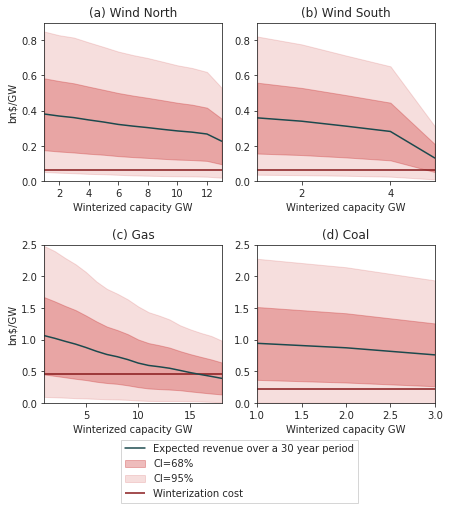

In [6]:
sns.set_style("ticks")

(fig,((ax1,ax2),(ax3,ax4))) = plt.subplots(2,2,figsize=(7,7))

# WIND NORTH
m = marginal_revenue_windN_long.groupby('variable').mean().value
q95l = marginal_revenue_windN_long.groupby('variable').quantile(q=0.025).value
q95u = marginal_revenue_windN_long.groupby('variable').quantile(q=0.975).value
q68l = marginal_revenue_windN_long.groupby('variable').quantile(q=0.16).value
q68u = marginal_revenue_windN_long.groupby('variable').quantile(q=0.84).value

ax1.plot(m,color=COLORS[4],label='30 years average\n avoided loss')
ax1.fill_between(x = range(1,len(m)+1),y1=q68l.values,y2=q68u.values,color=COLORS[0],alpha=0.3,label='CI=68%')
ax1.fill_between(x = range(1,len(m)+1),y1=q95l.values,y2=q95u.values,color=COLORS[0],alpha=0.15,label='CI=95%')
ax1.hlines(winterization_wind/1000, 1, len(m),color=COLORS[5], label='Winterization cost')
ax1.set_xlabel('Winterized capacity GW')
ax1.set_ylabel('bn$/GW')
ax1.set_title('(a) Wind North')
ax1.set_xlim((1,len(m)))
ax1.set_ylim((0,0.9))
ax1.set_xticks(np.arange(2,len(m),2))

# WIND SOUTH
m = marginal_revenue_windS_long.groupby('variable').mean().value
q95l = marginal_revenue_windS_long.groupby('variable').quantile(q=0.025).value
q95u = marginal_revenue_windS_long.groupby('variable').quantile(q=0.975).value
q68l = marginal_revenue_windS_long.groupby('variable').quantile(q=0.16).value
q68u = marginal_revenue_windS_long.groupby('variable').quantile(q=0.84).value

ax2.plot(m,color=COLORS[4],label='30 years average\n avoided loss')
ax2.fill_between(x = range(1,len(m)+1),y1=q68l.values,y2=q68u.values,color=COLORS[0],alpha=0.3,label='CI=68%')
ax2.fill_between(x = range(1,len(m)+1),y1=q95l.values,y2=q95u.values,color=COLORS[0],alpha=0.15,label='CI=95%')
ax2.hlines(winterization_wind/1000, 1, len(m),color=COLORS[5], label='interization cost')
ax2.set_xlabel('Winterized capacity GW')
ax2.set_title('(b) Wind South')
ax2.set_xlim((1,len(m)))
ax2.set_ylim((0,0.9))
ax2.set_xticks(np.arange(2,len(m),2))

# GAS
m = marginal_revenue_gas_long.groupby('variable').mean().value
q95l = marginal_revenue_gas_long.groupby('variable').quantile(q=0.025).value
q95u = marginal_revenue_gas_long.groupby('variable').quantile(q=0.975).value
q68l = marginal_revenue_gas_long.groupby('variable').quantile(q=0.16).value
q68u = marginal_revenue_gas_long.groupby('variable').quantile(q=0.84).value

#ax3.plot(m,color=COLORS[4],label='Expected marginal\navoided loss over\na 30 year period')
ax3.plot(m,color=COLORS[4],label='Expected revenue over a 30 year period')
ax3.fill_between(x = range(1,len(m)+1),y1=q68l.values,y2=q68u.values,color=COLORS[0],alpha=0.3,label='CI=68%')
ax3.fill_between(x = range(1,len(m)+1),y1=q95l.values,y2=q95u.values,color=COLORS[0],alpha=0.15,label='CI=95%')
#ax3.hlines(winterization_gas/1000, 1, len(m),color=COLORS[5], label='Marginal\nwinterization\ncost')
ax3.hlines(winterization_gas/1000, 1, len(m),color=COLORS[5], label='Winterization cost')
ax3.set_xlabel('Winterized capacity GW')
ax3.set_ylabel('bn$/GW')
ax3.set_title('(c) Gas')
ax3.set_xlim((1,len(m)))
ax3.set_ylim((0,2.5))

# COAL
m = marginal_revenue_coal_long.groupby('variable').mean().value
q95l = marginal_revenue_coal_long.groupby('variable').quantile(q=0.025).value
q95u = marginal_revenue_coal_long.groupby('variable').quantile(q=0.975).value
q68l = marginal_revenue_coal_long.groupby('variable').quantile(q=0.16).value
q68u = marginal_revenue_coal_long.groupby('variable').quantile(q=0.84).value

ax4.plot(m,color=COLORS[4],label='30 years average\n avoided loss')
ax4.fill_between(x = range(1,len(m)+1),y1=q68l.values,y2=q68u.values,color=COLORS[0],alpha=0.3,label='CI=68%')
ax4.fill_between(x = range(1,len(m)+1),y1=q95l.values,y2=q95u.values,color=COLORS[0],alpha=0.15,label='CI=95%')
ax4.hlines(winterization_coal/1000, 1, len(m),color=COLORS[5], label='Winterization \ncost')
ax4.set_xlabel('Winterized capacity GW')
ax4.set_title('(d) Coal')
#lgd = ax4.legend(bbox_to_anchor=(1.05,1),loc='upper left')
ax4.set_xlim((1,len(m)))
ax4.set_ylim((0,2.5))

lgd = ax3.legend(loc='upper center', bbox_to_anchor=(1.1, -0.2),
          fancybox=False, shadow=False, ncol=1)

fig.subplots_adjust(hspace=0.4)


plt.savefig(fig_path + 'marginal_revenue_winterize_LR24temptrend_Hook-8.pdf',dpi=300,
           bbox_extra_artists=(lgd,), bbox_inches='tight')

sns.set_style("white")

# run scenarios of competition profit

In [18]:
from scipy.interpolate import interp1d

In [19]:
in_path = '/data/projects/texas-power-outages/data/input/'

In [20]:
# read scarcity price function
ordc = pd.read_excel(in_path + "orcd/ordc.xls").drop([13,14]) # remove two values because of unsteadyness
caps = np.concatenate([[-50000],ordc.capacity_available.values,[90000]])
prices = np.concatenate([[9000],ordc[' ordc_price_adder'].values,[0]])
prices[prices<0] = 0

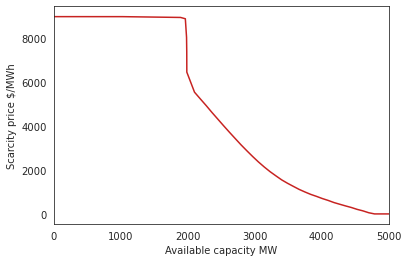

In [30]:
plt.plot(caps,prices)
plt.xlim((0,5000))
plt.xlabel('Available capacity MW')
plt.ylabel('Scarcity price $/MWh')
plt.savefig(fig_path + 'scarcity_prices.pdf',dpi=300,bbox_inches='tight')

In [32]:
pd.DataFrame({'capacity':caps,
              'price':prices}).to_csv(fig_path_raw + 'FigA11.csv')

#### fit price function

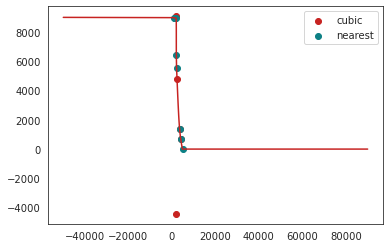

In [21]:
plt.plot(caps,prices)

price_func = interp1d(caps,prices, kind='cubic')
x = [1500,1900,2000,2100,3500,4000]
plt.scatter(x,price_func(x),label='cubic')

price_func = interp1d(caps,prices, kind='nearest')
x = [1000,1500,1900,2000,2100,3500,4000,5000]
plt.scatter(x,price_func(x),label='nearest')

plt.legend()

Text(0, 0.5, 'ERCOT price $/MW')

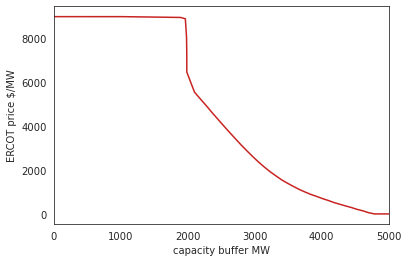

In [29]:
plt.plot(caps,prices)
plt.xlim((0,5000))
plt.xlabel('capacity buffer MW')
plt.ylabel('ERCOT price $/MW')

### prepare thresholds

In [14]:
thresh_gas = get_thresh(temppp.NG,THRESH_GAS_TEMP,REC_GAS_TEMP,MAXOUT_GAS,K_GAS)
thresh_coal = get_thresh(temppp.COAL,THRESH_COAL_TEMP,REC_COAL_TEMP,MAXOUT_COAL,K_COAL)
thresh_windN = get_thresh(tempwpNS.t2mNorth,THRESH_WINDN_TEMP,REC_WINDN_TEMP,MAXOUT_WINDN,K_WINDN)
thresh_windS = get_thresh(tempwpNS.t2mSouth,THRESH_WINDS_TEMP,REC_WINDS_TEMP,MAXOUT_WINDS,K_WINDS)

### run scenarios

In [ ]:
def run_redout_scenarioCOMP_technology(thresh_gas,thresh_coal,thresh_windN,thresh_windS,sampleyears,technology,price_func):
    # define discount rate
    discount = 1.05 ** (-np.arange(1,31))
    #discount = 1.1 ** (-np.arange(1,31))

    maxout = int(round(out_model_param.outage_capacity[technology]))
    results_matrix = np.zeros((maxout,10000))
    for reduced_GW in range(1,maxout+1):
        print('reduced GW',reduced_GW)
        # GET THRESHOLDS
        if technology == 'gas':
            thresh_gasR = thresh_gas - reduced_GW
            thresh_gasR[thresh_gasR<0] = 0
            thresh_gasNR = thresh_gas - (reduced_GW - 1)
            thresh_gasNR[thresh_gasNR<0] = 0
            thresh_gas_coalR = 62 - (thresh_gasR + thresh_coal)
            thresh_gas_coalNR = 62 - (thresh_gasNR + thresh_coal)
            wp_remainR = wp/10**6*(33-thresh_windN-thresh_windS)/33
            wp_remainNR = wp/10**6*(33-thresh_windN-thresh_windS)/33
        elif technology == 'coal':
            thresh_coalR = thresh_coal - reduced_GW
            thresh_coalR[thresh_coalR<0] = 0
            thresh_coalNR = thresh_coal - (reduced_GW - 1)
            thresh_coalNR[thresh_coalNR<0] = 0
            thresh_gas_coalR = 62 - (thresh_gas + thresh_coalR)
            thresh_gas_coalNR = 62 - (thresh_gas + thresh_coalNR)
            wp_remainR = wp/10**6*(33-thresh_windN-thresh_windS)/33
            wp_remainNR = wp/10**6*(33-thresh_windN-thresh_windS)/33
        elif technology == 'wind_north':
            thresh_windNR = thresh_windN - reduced_GW
            thresh_windNR[thresh_windNR<0] = 0
            thresh_windNNR = thresh_windN - (reduced_GW - 1)
            thresh_windNNR[thresh_windNNR<0] = 0
            thresh_gas_coalR = 62 - (thresh_gas + thresh_coal)
            thresh_gas_coalNR = 62 - (thresh_gas + thresh_coal)
            wp_remainR = wp/10**6*(33-thresh_windNR-thresh_windS)/33
            wp_remainNR = wp/10**6*(33-thresh_windNNR-thresh_windS)/33
        else:
            thresh_windSR = thresh_windS - reduced_GW
            thresh_windSR[thresh_windSR<0] = 0
            thresh_windSNR = thresh_windS - (reduced_GW - 1)
            thresh_windSNR[thresh_windSNR<0] = 0
            thresh_gas_coalR = 62 - (thresh_gas + thresh_coal)
            thresh_gas_coalNR = 62 - (thresh_gas + thresh_coal)
            wp_remainR = wp/10**6*(33-thresh_windN-thresh_windSR)/33
            wp_remainNR = wp/10**6*(33-thresh_windN-thresh_windSNR)/33
        # calculate total thresholds
        thresh_totalR = thresh_gas_coalR + wp_remainR
        thresh_totalNR = thresh_gas_coalNR + wp_remainNR
        # calculate deficits
        deficitR = load70.load_est/1000-thresh_totalR
        deficitNR = load70.load_est/1000-thresh_totalNR
        # calculate capacity for which revenue is gained
        
        #cap_rev = deficitNR[(deficitNR>0)]#
        #cap_rev[cap_rev>1] = 1
        deficitRcap = deficitR.copy(deep=True)
        deficitRcap[deficitR<0]=0
        deficitNRcap = deficitNR.copy(deep=True)
        deficitNRcap[deficitNR<0]=0
        cap_rev = deficitNRcap - deficitRcap
        
        # calculate price
        price = pd.Series(price_func(-deficitR*1000),index=deficitR.index)
        # calculate revenue for winterized GW
        rev = (cap_rev*1000*price)
        
        events = rev.resample('Y').count().replace(0,np.nan).dropna()
        yearly_rev = rev.resample('Y').sum()
        yearly_rev.index = yearly_rev.index.year
        yearly_rev = pd.Series(pd.Index(range(1950,2022)).map(yearly_rev).fillna(0),index=range(1950,2022))
        yearly_cap_rev = cap_rev.resample('Y').sum()
        yearly_cap_rev.index = yearly_cap_rev.index.year
        yearly_cap_rev = pd.Series(pd.Index(range(1950,2022)).map(yearly_cap_rev).fillna(0),index=range(1950,2022))
        
        # bootstrap
        bootstrap = 0
        for years in sampleyears:
            bootstrap = bootstrap + 1
            rev_per_GW = (yearly_rev[years] * discount).sum() / 10**9
            #if rev_per_GW > 0:
            #    rev_per_GW = (yearly_rev[years] * discount).sum()/yearly_cap_rev[years].sum()
            results_matrix[reduced_GW-1,bootstrap -1]= rev_per_GW
    return(results_matrix)

In [ ]:
scen_bootstrapCOMP_coal = run_redout_scenarioCOMP_technology(thresh_gas,thresh_coal,thresh_windN,thresh_windS,
                                                             bootstrap_year,'coal',price_func)
scen_bootstrapCOMP_windN = run_redout_scenarioCOMP_technology(thresh_gas,thresh_coal,thresh_windN,thresh_windS,
                                                              bootstrap_year,'wind_north',price_func)
scen_bootstrapCOMP_windS = run_redout_scenarioCOMP_technology(thresh_gas,thresh_coal,thresh_windN,thresh_windS,
                                                              bootstrap_year,'wind_south',price_func)
scen_bootstrapCOMP_gas = run_redout_scenarioCOMP_technology(thresh_gas,thresh_coal,thresh_windN,thresh_windS,
                                                            bootstrap_year,'gas',price_func)

In [ ]:
plt.plot(range(1,len(scen_bootstrapCOMP_coal)+1),scen_bootstrapCOMP_coal.mean(axis=1),label='coal')
plt.plot(range(1,len(scen_bootstrapCOMP_gas)+1),scen_bootstrapCOMP_gas.mean(axis=1),label='gas')
plt.plot(range(1,len(scen_bootstrapCOMP_windN)+1),scen_bootstrapCOMP_windN.mean(axis=1),label='windS')
plt.plot(range(1,len(scen_bootstrapCOMP_windS)+1),scen_bootstrapCOMP_windS.mean(axis=1),label='windN')
plt.legend()
plt.xlabel('GW  winterized')
plt.ylabel('marginal revenue bn$/GW')

In [ ]:
plt.plot(marginal_revenue_gas.mean(axis=1) - scen_bootstrapCOMP_gas.mean(axis=1))

In [ ]:
plt.plot(scen_bootstrapCOMP_gas.mean(axis=1),label='revenue')
plt.plot(marginal_revenue_gas.mean(axis=1),label='avoided loss')
plt.legend()
plt.xlabel('GW  winterized -1')
plt.ylabel('revenue bn$/GW')

# run scenarios for monopoly profit

In [40]:
def run_redout_scenarioMONO_technology(thresh_gas,thresh_coal,thresh_windN,thresh_windS,sampleyears,technology,price_func):
    # define discount rate
    discount = 1.05 ** (-np.arange(1,31))
    #discount = 1.1 ** (-np.arange(1,31))

    maxout = int(round(out_model_param.outage_capacity[technology]))
    results_matrix = np.zeros((maxout+1,10000))
    for reduced_GW in range(0,maxout+1):
        print('reduced GW',reduced_GW)
        # GET THRESHOLDS
        if technology == 'gas':
            thresh_gasR = thresh_gas - reduced_GW
            thresh_gasR[thresh_gasR<0] = 0
            thresh_gas_coalR = 63.5 - (thresh_gasR + thresh_coal)
            wp_remainR = wp/10**6*(33-thresh_windN-thresh_windS)/33
        elif technology == 'coal':
            thresh_coalR = thresh_coal - reduced_GW
            thresh_coalR[thresh_coalR<0] = 0
            thresh_gas_coalR = 63.5 - (thresh_gas + thresh_coalR)
            wp_remainR = wp/10**6*(33-thresh_windN-thresh_windS)/33
        elif technology == 'wind_north':
            thresh_windNR = thresh_windN - reduced_GW
            thresh_windNR[thresh_windNR<0] = 0
            thresh_gas_coalR = 63.5 - (thresh_gas + thresh_coal)
            wp_remainR = wp/10**6*(33-thresh_windNR-thresh_windS)/33
        else:
            thresh_windSR = thresh_windS - reduced_GW
            thresh_windSR[thresh_windSR<0] = 0
            thresh_gas_coalR = 63.5 - (thresh_gas + thresh_coal)
            wp_remainR = wp/10**6*(33-thresh_windN-thresh_windSR)/33
        # calculate total thresholds
        thresh_totalR = thresh_gas_coalR + wp_remainR
        # calculate deficits
        deficitR = load70.load_est/1000-thresh_totalR
        # calculate production capacity
        cap_rev = pd.concat([thresh_totalR,load70.load_est/1000],axis=1).min(axis=1)
        
        # calculate price
        price = pd.Series(price_func(-deficitR*1000),index=deficitR.index)
        # calculate revenue for winterized GW
        rev = (cap_rev*1000*price)
        
        events = rev.resample('Y').count().replace(0,np.nan).dropna()
        yearly_rev = rev.resample('Y').sum()
        yearly_rev.index = yearly_rev.index.year
        yearly_rev = pd.Series(pd.Index(range(1950,2022)).map(yearly_rev).fillna(0),index=range(1950,2022))
        yearly_cap_rev = cap_rev.resample('Y').sum()
        yearly_cap_rev.index = yearly_cap_rev.index.year
        yearly_cap_rev = pd.Series(pd.Index(range(1950,2022)).map(yearly_cap_rev).fillna(0),index=range(1950,2022))
        
        # bootstrap
        bootstrap = 0
        for years in sampleyears:
            bootstrap = bootstrap + 1
            rev_per_GW = (yearly_rev[years] * discount).sum() / 10**9
            #if rev_per_GW > 0:
            #    rev_per_GW = (yearly_rev[years] * discount).sum()/yearly_cap_rev[years].sum()
            results_matrix[reduced_GW,bootstrap -1]= rev_per_GW
    return(results_matrix)

In [46]:
scen_bootstrapMONO_coal = run_redout_scenarioMONO_technology(thresh_gas,thresh_coal,thresh_windN,thresh_windS,
                                                             bootstrap_year,'coal',price_func)
scen_bootstrapMONO_windN = run_redout_scenarioMONO_technology(thresh_gas,thresh_coal,thresh_windN,thresh_windS,
                                                              bootstrap_year,'wind_north',price_func)
scen_bootstrapMONO_windS = run_redout_scenarioMONO_technology(thresh_gas,thresh_coal,thresh_windN,thresh_windS,
                                                              bootstrap_year,'wind_south',price_func)
scen_bootstrapMONO_gas = run_redout_scenarioMONO_technology(thresh_gas,thresh_coal,thresh_windN,thresh_windS,
                                                            bootstrap_year,'gas',price_func)

reduced GW 0
reduced GW 1
reduced GW 2
reduced GW 3
reduced GW 0
reduced GW 1
reduced GW 2
reduced GW 3
reduced GW 4
reduced GW 5
reduced GW 6
reduced GW 7
reduced GW 8
reduced GW 9
reduced GW 10
reduced GW 11
reduced GW 12
reduced GW 13
reduced GW 0
reduced GW 1
reduced GW 2
reduced GW 3
reduced GW 4
reduced GW 5
reduced GW 0
reduced GW 1
reduced GW 2
reduced GW 3
reduced GW 4
reduced GW 5
reduced GW 6
reduced GW 7
reduced GW 8
reduced GW 9
reduced GW 10
reduced GW 11
reduced GW 12
reduced GW 13
reduced GW 14
reduced GW 15
reduced GW 16
reduced GW 17
reduced GW 18


Text(0, 0.5, 'total revenue bn$')

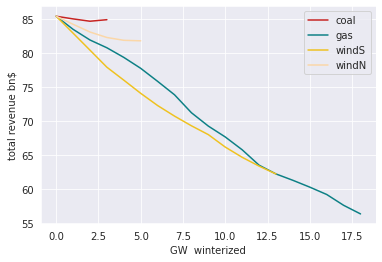

In [47]:
plt.plot(scen_bootstrapMONO_coal.mean(axis=1),label='coal')
plt.plot(scen_bootstrapMONO_gas.mean(axis=1),label='gas')
plt.plot(scen_bootstrapMONO_windN.mean(axis=1),label='windS')
plt.plot(scen_bootstrapMONO_windS.mean(axis=1),label='windN')
plt.legend()
plt.xlabel('GW  winterized')
plt.ylabel('total revenue bn$')

In [48]:
marginal_revenueMONO_coal = (scen_bootstrapMONO_coal[1:,] - scen_bootstrapMONO_coal[:-1,]).mean(axis=1)
marginal_revenueMONO_gas = (scen_bootstrapMONO_gas[1:,] - scen_bootstrapMONO_gas[:-1,]).mean(axis=1)
marginal_revenueMONO_windN = (scen_bootstrapMONO_windN[1:,] - scen_bootstrapMONO_windN[:-1,]).mean(axis=1)
marginal_revenueMONO_windS = (scen_bootstrapMONO_windS[1:,] - scen_bootstrapMONO_windS[:-1,]).mean(axis=1)

Text(0, 0.5, 'marginal revenue bn$/GW')

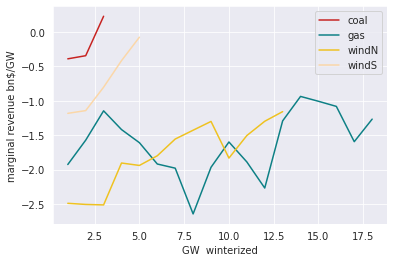

In [49]:
plt.plot(range(1,len(marginal_revenueMONO_coal)+1),marginal_revenueMONO_coal,label='coal')
plt.plot(range(1,len(marginal_revenueMONO_gas)+1),marginal_revenueMONO_gas,label='gas')
plt.plot(range(1,len(marginal_revenueMONO_windN)+1),marginal_revenueMONO_windN,label='windN')
plt.plot(range(1,len(marginal_revenueMONO_windS)+1),marginal_revenueMONO_windS,label='windS')
plt.legend()
plt.xlabel('GW  winterized')
plt.ylabel('marginal revenue bn$/GW')

# run scenarios for different share profit

In [15]:
thresh_gas_coal = 63.5 - (thresh_gas + thresh_coal)
wp_remain = wp/10**6*(33-thresh_windN-thresh_windS)/33
thresh_total = thresh_gas_coal + wp_remain

In [16]:
def run_redout_scenarioPART(thresh_gas,thresh_coal,wp_remain,thresh_total,sampleyears,price_func):
    # define discount rate
    discount = 1.05 ** (-np.arange(1,31))
    #discount = 1.1 ** (-np.arange(1,31))

    reduced_GW = 1
    maxown = 50
    results_matrix = np.zeros((maxown+1,10000))
    
    # GET THRESHOLDS
    thresh_gasR = thresh_gas - reduced_GW
    thresh_gasR[thresh_gasR<0] = 0
    thresh_gas_coalR = 63.5 - (thresh_gasR + thresh_coal)
    # calculate total thresholds
    thresh_totalR = thresh_gas_coalR + wp_remain

    # calculate deficits
    deficit = load70.load_est/1000-thresh_total
    deficitR = load70.load_est/1000-thresh_totalR
    
    # calculate capacity for which new revenue is gained
    deficitcap = deficit.copy(deep=True)
    deficitcap[deficit<0]=0
    deficitRcap = deficitR.copy(deep=True)
    deficitRcap[deficitR<0]=0
    cap_new_rev = deficitcap - deficitRcap
    
    # calculate price
    price = pd.Series(price_func(-deficit*1000),index=deficit.index)
    priceR = pd.Series(price_func(-deficitR*1000),index=deficitR.index)
    
    # calculate revenue from winterized GW
    rev_new = (cap_new_rev*1000*priceR)

    for cap_own in range(0,maxown+1):
        print('cap_own GW',cap_own)
        # calculate owned capacity for which profit is gained
        cap_own_rev = pd.concat([pd.Series(cap_own,index=thresh_total.index),thresh_total],axis=1).min(axis=1)
        
        # calculate revenue for winterized GW
        rev_own_winterized = cap_own_rev*1000*priceR
        total_rev_winterized = rev_new + rev_own_winterized
        rev_own_old = cap_own_rev*1000*price
        
        marginal_rev = total_rev_winterized - rev_own_old
        
        yearly_marginal_rev = marginal_rev.resample('Y').sum()
        yearly_marginal_rev.index = yearly_marginal_rev.index.year
        yearly_marginal_rev = pd.Series(pd.Index(range(1950,2022)).map(yearly_marginal_rev).fillna(0),index=range(1950,2022))       
        
        # bootstrap
        bootstrap = 0
        for years in sampleyears:
            bootstrap = bootstrap + 1
            rev_per_GW = (yearly_marginal_rev[years] * discount).sum() / 10**9
            results_matrix[cap_own,bootstrap -1]= rev_per_GW
    return(results_matrix)

In [23]:
scen_bootstrapPART = run_redout_scenarioPART(thresh_gas,thresh_coal,wp_remain,thresh_total,
                                                             bootstrap_year,price_func)

cap_own GW 0
cap_own GW 1
cap_own GW 2
cap_own GW 3
cap_own GW 4
cap_own GW 5
cap_own GW 6
cap_own GW 7
cap_own GW 8
cap_own GW 9
cap_own GW 10
cap_own GW 11
cap_own GW 12
cap_own GW 13
cap_own GW 14
cap_own GW 15
cap_own GW 16
cap_own GW 17
cap_own GW 18
cap_own GW 19
cap_own GW 20
cap_own GW 21
cap_own GW 22
cap_own GW 23
cap_own GW 24
cap_own GW 25
cap_own GW 26
cap_own GW 27
cap_own GW 28
cap_own GW 29
cap_own GW 30
cap_own GW 31
cap_own GW 32
cap_own GW 33
cap_own GW 34
cap_own GW 35
cap_own GW 36
cap_own GW 37
cap_own GW 38
cap_own GW 39
cap_own GW 40
cap_own GW 41
cap_own GW 42
cap_own GW 43
cap_own GW 44
cap_own GW 45
cap_own GW 46
cap_own GW 47
cap_own GW 48
cap_own GW 49
cap_own GW 50


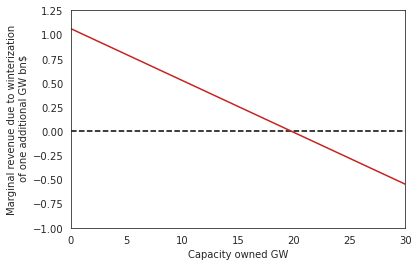

In [24]:
plt.plot(scen_bootstrapPART.mean(axis=1))
plt.xlabel('Capacity owned GW')
plt.ylabel('Marginal revenue due to winterization\n of one additional GW bn$')
plt.hlines(0,0,50,ls='--',color='black')
plt.xlim(0,30)
plt.ylim(-1,1.25)
plt.savefig(fig_path + 'owned_capacity_marginal_revenue_LR24temptrend_Hook-8.pdf',dpi=300,bbox_inches='tight')

In [26]:
pd.Series(scen_bootstrapPART.mean(axis=1)).to_csv(fig_path_raw + 'FigA4.csv')